# Load data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from dataset import get_dataset, N_TRADING_DAYS


df = get_dataset()
assert df.isna().sum().sum() == 0
df_returns = df.pct_change().dropna()

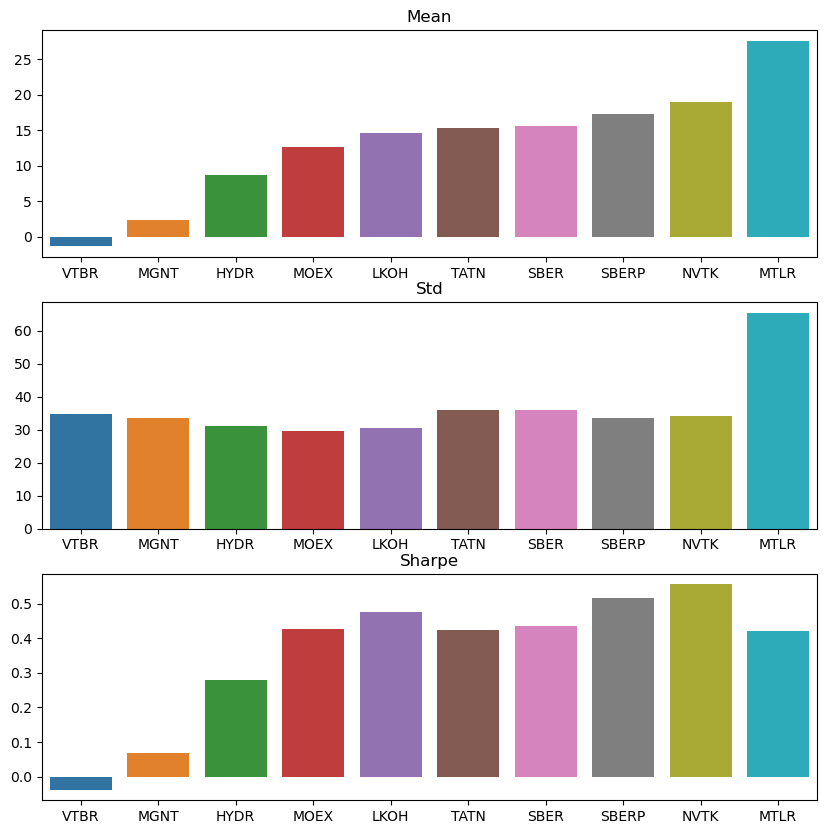

In [3]:
tickers = df_returns.columns
means = df_returns.mean() * N_TRADING_DAYS * 100
stds = df_returns.std() * np.sqrt(N_TRADING_DAYS) * 100
sharpe = means / stds
sorted_ind = np.argsort(means)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

ax1.set_title('Mean')
sns.barplot(x=tickers[sorted_ind], y=means[sorted_ind], ax=ax1)

ax2.set_title('Std')
sns.barplot(x=tickers[sorted_ind], y=stds[sorted_ind], ax=ax2)

ax3.set_title('Sharpe')
sns.barplot(x=tickers[sorted_ind], y=sharpe[sorted_ind], ax=ax3)

plt.show()

In [4]:
def print_statistics(w: pd.Series, df_returns: pd.DataFrame):
    assert np.all(w.index == df_returns.columns)
    assert np.isclose(w.sum(), 1), w.sum()
    returns = df_returns @ w
    mean = returns.mean() * N_TRADING_DAYS * 100
    std = returns.std() * np.sqrt(N_TRADING_DAYS) * 100
    sharpe = mean / std
    print(f'Return: {mean:.1f}% ± {std:.1f}%')
    print(f'Sharpe: {sharpe:.2f}')


print_statistics(pd.Series(np.full(len(df_returns.columns), 1 / len(df_returns.columns)), index=df_returns.columns), df_returns)

Return: 13.2% ± 25.1%
Sharpe: 0.52


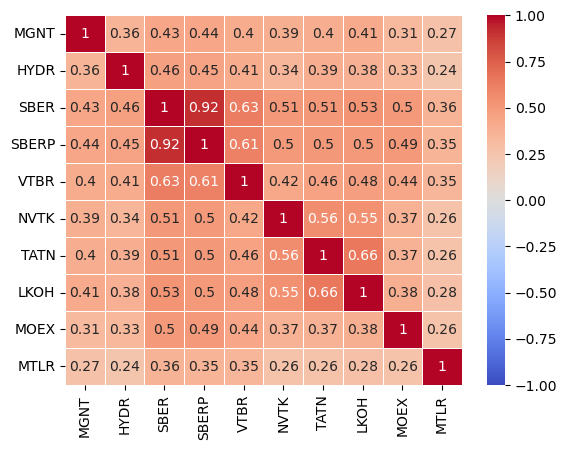

In [5]:
import scipy.cluster.hierarchy as sch
import warnings


def get_distance_matrix(Sigma: pd.DataFrame) -> pd.DataFrame:
    result = np.sqrt(0.5 * (1 - np.minimum(Sigma, 1.0)))
    result.iloc[range(len(Sigma)), range(len(Sigma))] = 0.0
    return result


def sort_corr(corr_matrix: pd.DataFrame) -> list[str]:
    corr_matrix = corr_matrix.copy()
    distance_matrix = get_distance_matrix(corr_matrix)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        linkage_matrix = sch.complete(distance_matrix)
    cluster_labels = sch.fcluster(linkage_matrix, 6, criterion='maxclust')

    sorted_cols_and_orders = sorted(
        list(zip(corr_matrix.columns, cluster_labels)), key=lambda x: x[1]
    )
    sorted_cols, _ = list(map(list, list(zip(*sorted_cols_and_orders))))
    return sorted_cols


sorted_labels = sort_corr(df_returns.corr())


def plot_correlation_matrix(Sigma: pd.DataFrame):
    if np.all(np.isin(sorted_labels, Sigma.columns)):
        Sigma = Sigma.loc[sorted_labels, sorted_labels]
    sns.heatmap(Sigma, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)


plot_correlation_matrix(df_returns.corr())

# GANs

## Dataset

In [6]:
df_returns = df_returns[['SBER', 'SBERP']]

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader


class ReturnsDataset(Dataset):
    def __init__(self, df_returns: pd.DataFrame, window_size: int):
        self.data = df_returns.values.astype(np.float32)
        self.columns = df_returns.columns.copy()
        self.window_size = window_size
        self.length = self.data.shape[0] - window_size + 1

    def __getitem__(self, ind: int):
        return torch.from_numpy(self.data[ind:ind+self.window_size])

    def __len__(self):
        return self.length


WINDOW_SIZE = 100
BATCH_SIZE = 1024
N_ASSETS = len(df_returns.columns)

dataset = ReturnsDataset(df_returns, window_size=WINDOW_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
assert dataset[0].size() == dataset[len(dataset) - 1].size() == (WINDOW_SIZE, N_ASSETS)
df_returns.shape

(2464, 2)

In [63]:
import torch
from torch import nn, optim


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [77]:
DISCRIMINATOR_HIDDEN_SIZE = 50
GENERATOR_HIDDEN_SIZE = 50

NOISE_SIZE = N_ASSETS * 2


class DiscriminatorLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=N_ASSETS, hidden_size=DISCRIMINATOR_HIDDEN_SIZE, num_layers=1, batch_first=True)
        self.linear = nn.Linear(DISCRIMINATOR_HIDDEN_SIZE * WINDOW_SIZE, 1)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x.size() = (BATCH_SIZE, WINDOW_SIZE, N_ASSETS)
        x, _ = self.lstm(x)
        # x.size() = (BATCH_SIZE, WINDOW_SIZE, HIDDEN_SIZE)
        x = self.flatten(x)
        # x.size() = (BATCH_SIZE, WINDOW_SIZE * HIDDEN_SIZE)
        x = self.linear(x).squeeze(-1)
        # x.size() = (BATCH_SIZE)
        return self.sigmoid(x)  # [0, 1]


class GeneratorLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=NOISE_SIZE, hidden_size=GENERATOR_HIDDEN_SIZE, num_layers=1, batch_first=True)
        self.linear = nn.Linear(GENERATOR_HIDDEN_SIZE, N_ASSETS)

    def forward(self, x):
        # x.size() = (BATCH_SIZE, NOISE_SIZE)
        x, _ = self.lstm(x)
        # x.size() = (BATCH_SIZE, WINDOW_SIZE, HIDDEN_SIZE)
        x = self.linear(x)
        # x.size() = (BATCH_SIZE, WINDOW_SIZE, N_ASSETS)
        return x


def get_noise(batch_size: int):
    return torch.randn(batch_size, WINDOW_SIZE, NOISE_SIZE)


assert DiscriminatorLSTM()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert GeneratorLSTM()(get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

In [79]:
class DiscriminatorCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # (WINDOW_SIZE, )
        self.conv1 = nn.Conv1d(in_channels=N_ASSETS, out_channels=8, kernel_size=3)
        # (WINDOW_SIZE - 2, )
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        # (WINDOW_SIZE // 2 - 1, )
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=3)
        # (WINDOW_SIZE // 2 - 3, )
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)
        # ((WINDOW_SIZE // 2 - 3) // 2, )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * ((WINDOW_SIZE // 2 - 3) // 2), 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.transpose(-1, -2)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc(x).squeeze()
        return self.sigmoid(x)


class GeneratorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(NOISE_SIZE, 8, kernel_size=3),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.ConvTranspose1d(8, 16, kernel_size=5),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 8, kernel_size=5),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.ConvTranspose1d(8, N_ASSETS, kernel_size=7),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.transpose(-1, -2)
        x = self.main(x)
        return x.transpose(-1, -2)


def get_noise(batch_size: int):
    return torch.randn(batch_size, WINDOW_SIZE - 16, NOISE_SIZE)


assert DiscriminatorCNN()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert GeneratorCNN()(get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

Fake correlation: 0.31049165814421215. Real correlation: 0.9166666150555096


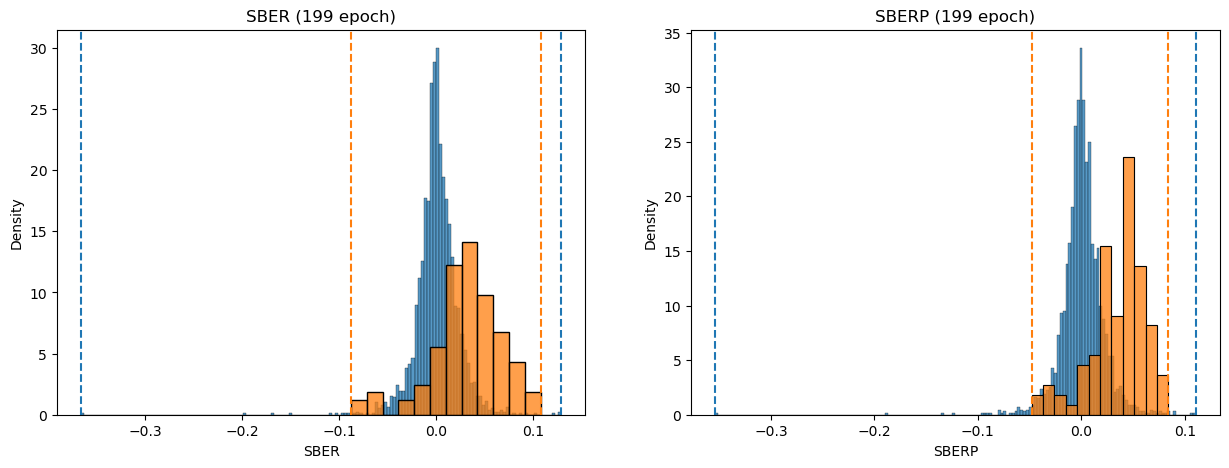

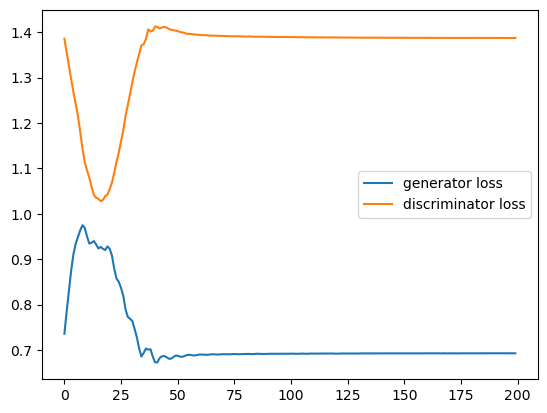

In [80]:
from tqdm.notebook import tqdm
from IPython.display import clear_output


def train_epoch(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader):
    generator_losses = []
    discriminator_losses = []
    for real_samples in dataloader:  # Iterate over batches of real samples
        real_samples = real_samples.to(DEVICE)

        # Generate fake samples from the generator
        z = get_noise(real_samples.shape[0]).to(DEVICE)  # Sample noise
        with torch.no_grad():
            fake_samples = generator(z)
        real_labels = torch.ones(real_samples.shape[0]).to(DEVICE)
        fake_labels = torch.zeros(real_samples.shape[0]).to(DEVICE)

        # Train the discriminator
        discriminator_optimizer.zero_grad()
        # Compute discriminator loss on real samples
        real_loss = loss_fn(discriminator(real_samples), real_labels)
        # Compute discriminator loss on fake samples
        fake_loss = loss_fn(discriminator(fake_samples), fake_labels)
        # Compute the total discriminator loss
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Train the generator
        generator_optimizer.zero_grad()
        # Generate fake samples and compute generator loss
        fake_samples = generator(z)
        generator_loss = loss_fn(discriminator(fake_samples), real_labels)
        generator_loss.backward()
        generator_optimizer.step()

        discriminator_losses.append(discriminator_loss.item())
        generator_losses.append(generator_loss.item())
    return np.mean(generator_losses), np.mean(discriminator_losses)


@torch.no_grad()
def generate_samples(generator):
    df_returns_fake = pd.DataFrame(generator(get_noise(1).to(DEVICE)).squeeze().cpu(), columns=df_returns.columns)
    return df_returns_fake


def plot_gan(generator, epoch):
    df_returns_fake = generate_samples(generator)
    print(f'Fake correlation: {df_returns_fake.corr().iloc[0][1]}. Real correlation: {df_returns.corr().iloc[0][1]}')
    plt.subplots(1, 2, figsize=(15, 5))
    for i, col in enumerate(['SBER', 'SBERP']):
        plt.subplot(1, 2, i + 1)
        sns.histplot(df_returns[col], stat='density')
        sns.histplot(df_returns_fake[col], stat='density')
        plt.axvline(df_returns[col].min(), linestyle='dashed', color='C0')
        plt.axvline(df_returns[col].max(), linestyle='dashed', color='C0')
        plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
        plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')
        plt.title(f'{col} ({epoch} epoch)')
    plt.show()


def train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, n_epochs):
    generator_losses = []
    discriminator_losses = []

    for epoch in tqdm(range(n_epochs)):
        generator_loss, discriminator_loss = train_epoch(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader)
        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)

        if epoch % 30 == 0:
            clear_output(wait=True)
            plot_gan(generator, epoch)
    
    clear_output(wait=True)
    plot_gan(generator, epoch)
    plt.plot(generator_losses, label='generator loss')
    plt.plot(discriminator_losses, label='discriminator loss')
    plt.legend()
    plt.show()
    return generator_losses, discriminator_losses


N_EPOCHS = 200

# Define the loss function (e.g., binary cross-entropy)
loss_fn = nn.BCELoss()

discriminator = DiscriminatorCNN().to(DEVICE)
generator = GeneratorCNN().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 1e-3
generator_optimizer = optim.AdamW(generator.parameters(), lr=LR)
discriminator_optimizer = optim.AdamW(discriminator.parameters(), lr=LR)

_ = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, n_epochs=N_EPOCHS)
df_returns_fake = pd.DataFrame(generate_samples(generator), columns=df_returns.columns)

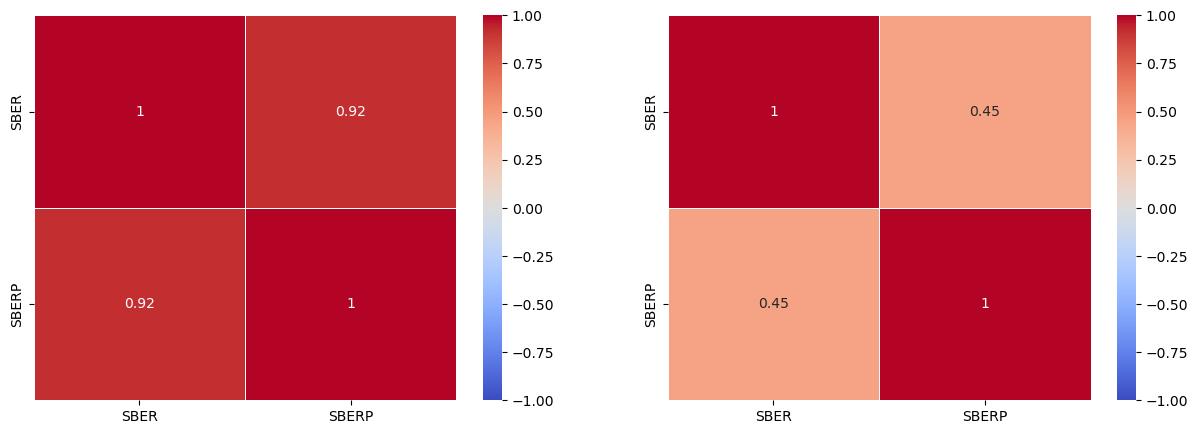

In [84]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns.corr())
plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.show()

<Axes: xlabel='date'>

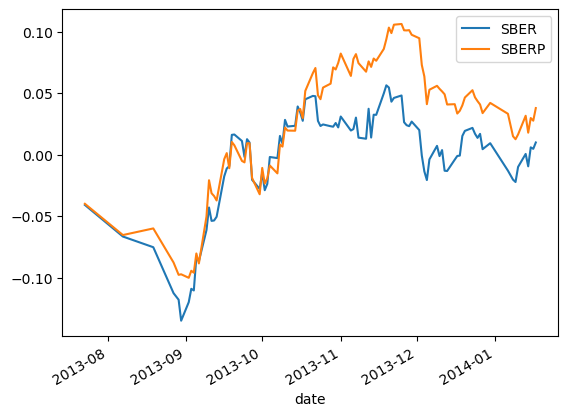

In [88]:
df_returns[:WINDOW_SIZE].cumsum().plot()

<Axes: >

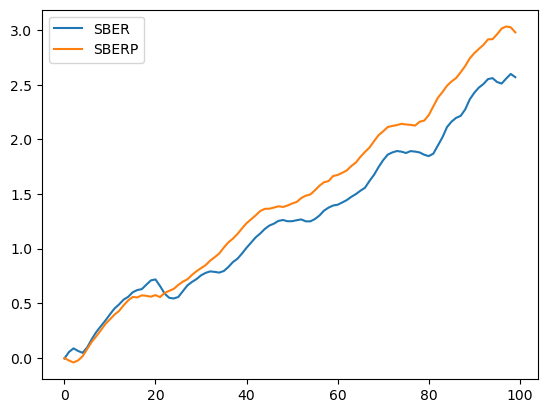

In [87]:
df_returns_fake.cumsum().plot()

In [83]:
df_returns_fake.tail()

,SBER,SBERP
95,-0.035943,0.044695
96,-0.013963,0.052216
97,0.045829,0.019120
98,0.042269,-0.007496
99,-0.029655,-0.046546
